# Part 1: Data Preprocessing

In [ ]:
import pandas as pd

IBM_data = pd.read_csv('IBM_data.csv')
IBM_data.rename(columns={IBM_data.columns[0]: 'date'}, inplace=True)

IBM_data.head()

,date,close,treasury_yield,^SP500-45,interest_rate
0,1999-11-01,96.75,5.16,605.730713,5.38
1,1999-11-02,94.81,5.14,605.990723,5.18
2,1999-11-03,94.37,5.12,615.300232,5.21
3,1999-11-04,91.56,5.10,621.889954,5.27
4,1999-11-05,90.25,5.14,629.349609,5.14


In [ ]:
IBM_data['date'] = pd.to_datetime(IBM_data['date'], errors='coerce')
IBM_data.set_index('date', inplace=True)

In [ ]:
# check num
nan_summary = IBM_data.isna().sum()
data_description = IBM_data.describe(include='all')
nan_summary, data_description

(close             2841
 treasury_yield    2608
 ^SP500-45         2846
 interest_rate        0
 dtype: int64,
               close treasury_yield    ^SP500-45  interest_rate
 count   6291.000000           6524  6286.000000    9132.000000
 unique          NaN            620          NaN            NaN
 top             NaN              .          NaN            NaN
 freq            NaN            269          NaN            NaN
 mean     131.843785            NaN   969.293597       1.925161
 std       36.459989            NaN   953.435191       2.030344
 min       55.070000            NaN   172.880005       0.040000
 25%      101.675000            NaN   346.052505       0.140000
 50%      129.000000            NaN   510.345001       1.170000
 75%      156.315000            NaN  1204.584961       3.502500
 max      235.260000            NaN  4616.319824       7.030000)

In [ ]:
IBM_data.head()

,close,treasury_yield,^SP500-45,interest_rate
date,,,,
1999-11-01,96.75,5.16,605.730713,5.38
1999-11-02,94.81,5.14,605.990723,5.18
1999-11-03,94.37,5.12,615.300232,5.21
1999-11-04,91.56,5.10,621.889954,5.27
1999-11-05,90.25,5.14,629.349609,5.14


## Check for Stationary

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
close_series = IBM_data['close'].dropna()

**Why choose ADF over KPSS**

- Simplicity: The ADF test is very common, and its output and interpretation are well-known and well-documented.

- Focus on Unit Root: The ADF test directly tests for a unit root (a form of non-stationarity). If the null hypothesis (that there is a unit root) can be rejected, it implies stationarity.


In [ ]:
result_adf = adfuller(close_series, autolag='AIC')
print("ADF Statistic: %f" % result_adf[0])
print("p-value: %f" % result_adf[1])
for key, value in result_adf[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.833666
p-value: 0.363880
Critical Values:
   1%, -3.4310676239754114
Critical Values:
   5%, -2.861857143718155
Critical Values:
   10%, -2.566938810551107


The results suggest that the IBM closing price series is likely non-stationary as it currently stands.

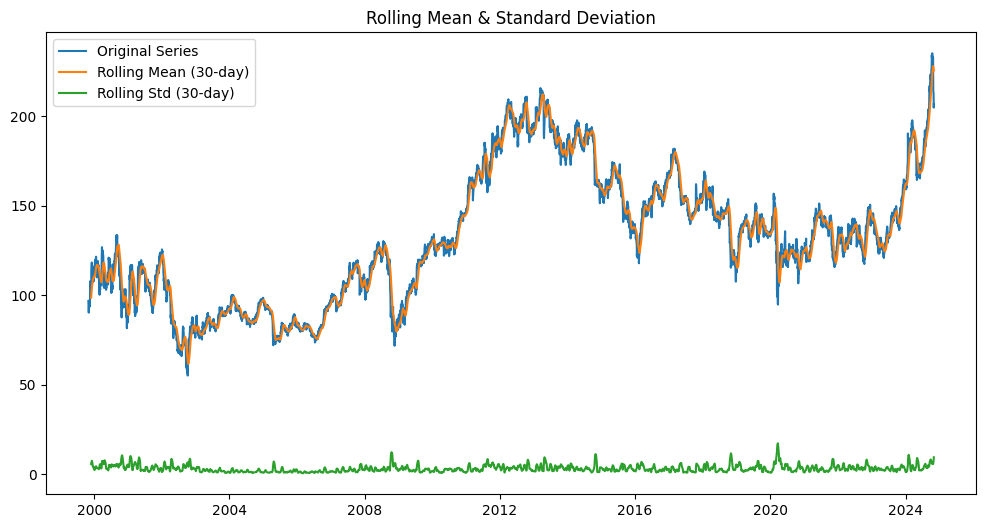

In [ ]:
import matplotlib.pyplot as plt

close_series = IBM_data['close'].dropna()

# Compute rolling mean and standard deviation
rolling_mean = close_series.rolling(window=30).mean()
rolling_std = close_series.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(close_series, label='Original Series')
plt.plot(rolling_mean, label='Rolling Mean (30-day)')
plt.plot(rolling_std, label='Rolling Std (30-day)')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()


In [ ]:
IBM_data['diff_close'] = IBM_data['close'].diff().dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# If you took just the difference of close prices:
diff_series = IBM_data['diff_close'].dropna()

result_adf_diff = adfuller(diff_series, autolag='AIC')
print("ADF Statistic (Differenced): %f" % result_adf_diff[0])
print("p-value: %f" % result_adf_diff[1])
for key, value in result_adf_diff[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic (Differenced): -23.107742
p-value: 0.000000
Critical Values:
   1%, -3.4310676239754114
Critical Values:
   5%, -2.861857143718155
Critical Values:
   10%, -2.566938810551107


By differencing the data once, the time series now appears to be stationary.


# Part 2: Baseline Model -- Arima

Implement Auto Arima with

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

auto_model = auto_arima(
    IBM_data['close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    max_d=2,
    seasonal=False,
    stepwise=True,
    trace=True,
    information_criterion='aic'
)
print(f"Optimal order: {auto_model.order}")
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34070.299, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34065.428, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34065.726, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34068.841, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34062.872, Time=1.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34064.871, Time=3.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=34064.872, Time=3.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34064.567, Time=9.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=34066.872, Time=4.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34061.362, Time=1.53 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34063.942, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=34063.361, Time=2.61 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=34063.362, Time=2.77 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34063.056, Time=4.96 sec
 ARIMA(3,1,1)(0,0,0

Refit ARIMA Model with Optimal Parameters


In [ ]:
train_size = int(len(IBM_data['close']) * 0.8)
train, test = IBM_data['close'][:train_size], IBM_data['close'][train_size:]

In [ ]:
# Fit ARIMA model

from statsmodels.tsa.arima.model import ARIMA

best_order = auto_model.order
model = ARIMA(train, order=best_order)
model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 7305
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -13298.394
Date:                Mon, 16 Dec 2024   AIC                          26602.789
Time:                        01:55:43   BIC                          26623.477
Sample:                    11-01-1999   HQIC                         26609.902
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0329      0.008      4.234      0.000       0.018       0.048
ar.L2          0.0237      0.010      2.305      0.021       0.004       0.044
sigma2         2.2334      0.013    168.775      0.0

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

fitted_values = model_fit.fittedvalues
rmse_training = np.sqrt(mean_squared_error(train, fitted_values))
print(f"RMSE for training predictions: {rmse_training}")

forecast = model_fit.forecast(steps=len(test))  # Forecast for test set
rmse_test = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE for test set predictions: {rmse_test}")

RMSE for training predictions: 1.8746951036311974
RMSE for test set predictions: 25.584963418229737


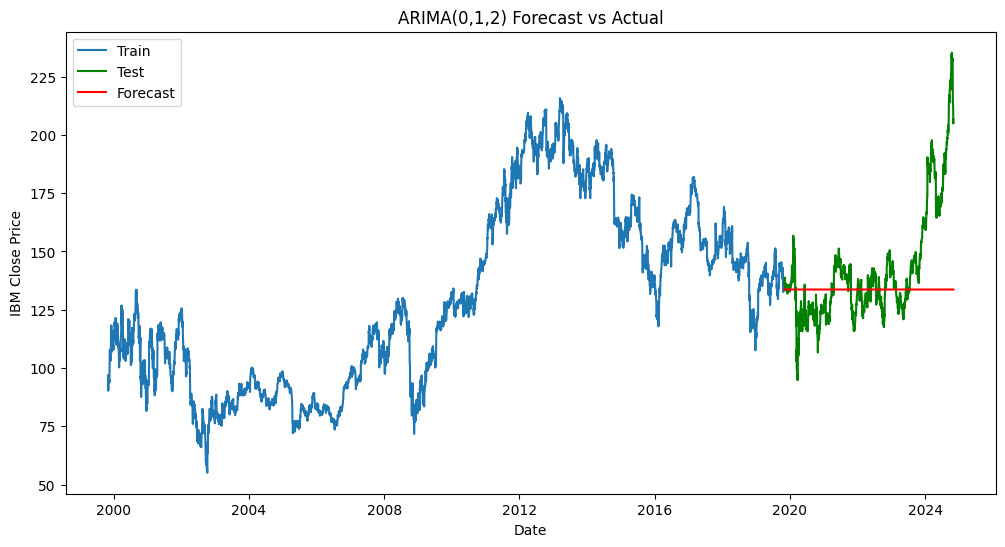

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('ARIMA(0,1,2) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('IBM Close Price')
plt.legend()
plt.show()

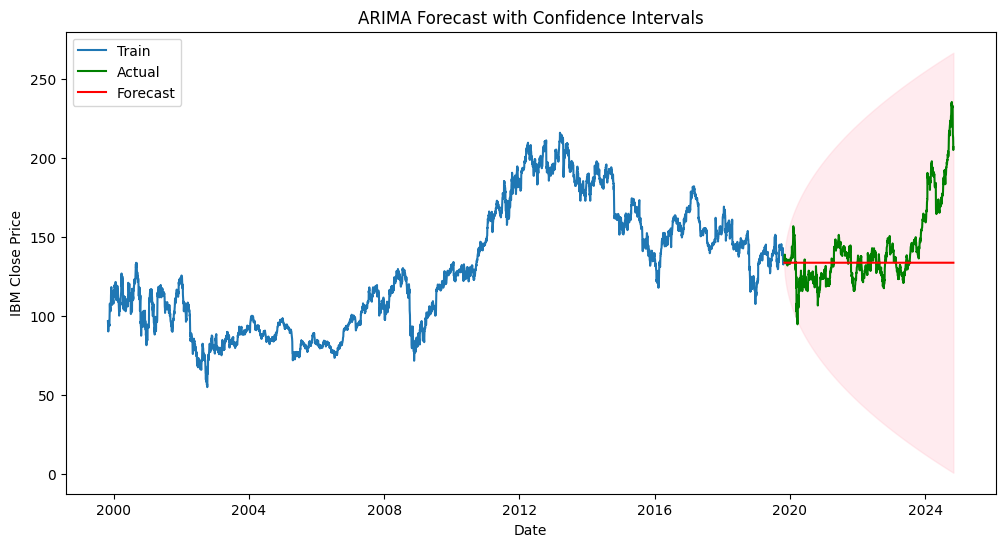

In [ ]:
prediction = model_fit.get_forecast(steps=steps)
pred_ci = prediction.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(test.index, prediction.predicted_mean, label='Forecast', color='red')
plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('IBM Close Price')
plt.legend()
plt.show()
